# Find Best Traces to Evaluate the Results

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dap.utils import obs_params, load_current
from dap import DAPcython

In [2]:
os.chdir('../')

In [3]:
from utils import calc_features_ramp, calc_features_step, find_spikes

## Load the Data 

#### Parameters

In [4]:
fname = 'dap_models_step_4_param_1x20.hdf'

df_steps = pd.read_hdf(fname, key='step_features')
df_ramps = pd.read_hdf(fname, key='ramp_features')
df_traces = pd.read_hdf(fname, key='param_traces')

In [5]:
df_traces.head(3)

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
Unnamed: 0,,,,,,,,,
1x10,17.101079,1.050186,143.711766,3.488044,769.204643,2779.176442,3548.381084,"[-75.00075208811397, -74.9749097530273, -74.95...","[-74.99827197945109, -75.02818681373506, -75.0..."
1x32,14.655440,1.057382,165.355144,3.330600,605.724341,2457.659765,3063.384106,"[-75.00867478206122, -75.05028511832606, -75.0...","[-75.01217862872082, -74.99668028686641, -75.0..."
1x15,12.973121,1.009918,159.443323,3.181375,849.208378,2199.449697,3048.658075,"[-75.0046320397057, -75.07906192182598, -75.12...","[-74.98498214779673, -75.00839940952916, -75.0..."


In [6]:
df_traces.index.rename('id', inplace=True)
df_traces.reset_index(level=0, inplace=True)
df_traces.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
0,1x10,17.101079,1.050186,143.711766,3.488044,769.204643,2779.176442,3548.381084,"[-75.00075208811397, -74.9749097530273, -74.95...","[-74.99827197945109, -75.02818681373506, -75.0..."
1,1x32,14.655440,1.057382,165.355144,3.330600,605.724341,2457.659765,3063.384106,"[-75.00867478206122, -75.05028511832606, -75.0...","[-75.01217862872082, -74.99668028686641, -75.0..."
2,1x15,12.973121,1.009918,159.443323,3.181375,849.208378,2199.449697,3048.658075,"[-75.0046320397057, -75.07906192182598, -75.12...","[-74.98498214779673, -75.00839940952916, -75.0..."


#### Original Data

In [7]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [8]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

### Run Best Fit for Comparison

In [9]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

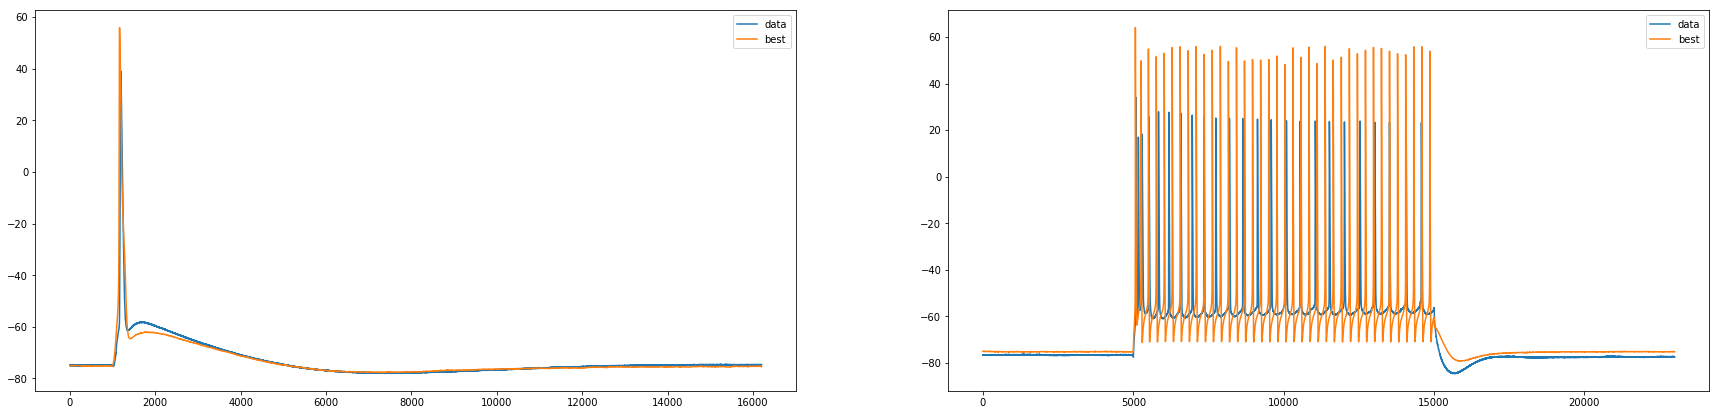

In [10]:
fig, ax  = plt.subplots(ncols=2, figsize=(30,7))
ax[0].plot(vr, label='data')
ax[0].plot(U, label='best')
ax[0].legend();

ax[1].plot(vs, label='data')
ax[1].plot(U_step, label='best');
ax[1].legend();

## Calculate The Features

In [11]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [12]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [13]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [14]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pick The Best For Both Currents

In [15]:
n = 2
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [16]:
df_best_ramps

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
14,1x23,0.332441,17.607268,0.02,5.158341,4.275709,0.11,0.550191,0.95,0.026949,29.030899
26,1x17,0.043122,17.222760,0.02,4.971010,4.181786,2.10,0.746102,0.93,0.529692,30.744472


In [17]:
df_best_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
2,1x15,2.123942,0.029393,8.0,3.055072,10.765110,4.0,23.973517
19,1x34,2.365065,0.018134,10.0,3.093168,10.161579,5.0,25.637946


## Merge With DFTraces to Get the best Traces and Parameters

In [21]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','ramp_traces', 'step_traces']

In [22]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps)
df_best_ramp_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
0,1x23,15.519491,1.099020,157.200629,3.315890,555.214958,2589.736855,3144.951813,"[-75.01348852778301, -75.00312721570891, -75.0...","[-74.99095464925635, -75.01051274808594, -75.0...",0.332441,17.607268,0.02,5.158341,4.275709,0.11,0.550191,0.95,0.026949,29.030899
1,1x17,15.691036,1.061033,154.425952,3.283569,558.110728,2661.556614,3219.667341,"[-74.9953113999311, -74.98203375005706, -74.98...","[-74.99157584510014, -74.98626775566404, -75.0...",0.043122,17.222760,0.02,4.971010,4.181786,2.10,0.746102,0.93,0.529692,30.744472


In [23]:
df_best_step_tr = pd.merge(df_traces, df_best_steps)[names]
df_best_step_tr

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,ramp_traces,step_traces
0,1x15,12.973121,1.009918,159.443323,3.181375,"[-74.98498214779673, -75.00839940952916, -75.0...","[-75.0046320397057, -75.07906192182598, -75.12..."
1,1x34,12.583342,1.103344,170.492587,3.121629,"[-75.00259213947807, -75.03218236097871, -75.0...","[-74.9928212697493, -75.10494327150683, -75.18..."


## Visualize Best Results of Given Batch

### Ramp Current

In [24]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.id

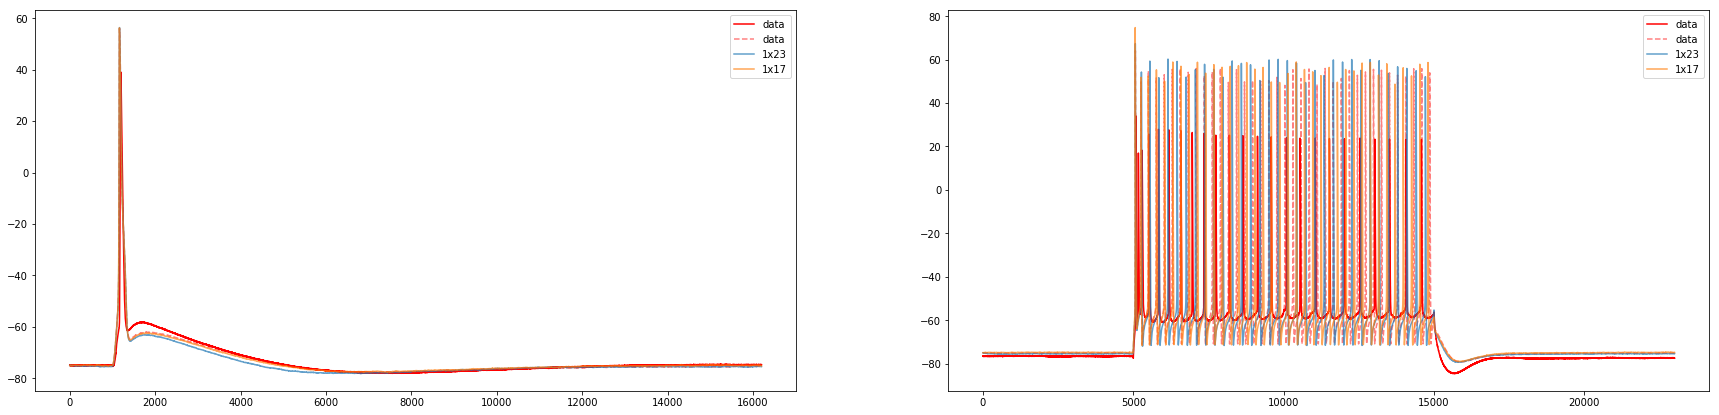

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, 'r--', alpha=0.5, label='data');

ax[1].plot(vs, c='r', label='data');
ax[1].plot(U_step, 'r--', alpha=0.5, label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [26]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.id

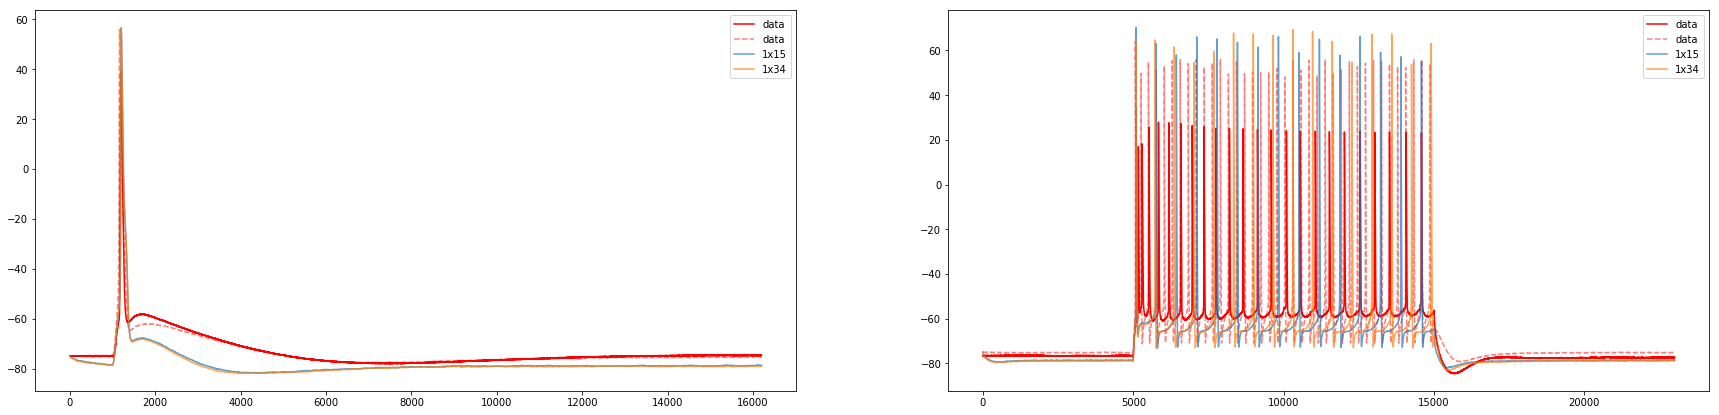

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, 'r--', alpha=0.5, label='data');

ax[1].plot(vs, c='r', label='data');
ax[1].plot(U_step, 'r--', alpha=0.5, label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();
